# Gemma Results

In [57]:
import copy
import sys
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb.apis

import wandb

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

api = wandb.Api()

In [58]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        model = (
            run.config["model"]
            .split("/")[1]
            .replace("-hf", "")
            .replace("-v0.1", "")
            .lower()
        )
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            squad_train="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]

        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            experiment=run.config["name"],
            task=task,
            confusion_contexts=run.config["task"].get("confusion_contexts"),
            wikitext_bugfix=run.config["code_changes"].get(
                "forced-sample-no-specials", False
            ),
            model=model,
            n_kv_heads=mc.get("num_key_value_heads", mc["num_attention_heads"])
            * mc["num_hidden_layers"],
            # NOTE: hidden_size // num_heads not true for Gemma
            head_size=mc.get(
                "head_dim", mc["hidden_size"] // mc["num_attention_heads"]
            ),
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
            id=run.id,
        )


def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(
        filter(
            None,
            (
                load_one(run)
                for run in api.runs(
                    "research/sparse-attention",
                    {
                        "$or": [
                            {"config.name": experiment_name},
                            *({"display_name": n} for n in single_runs),
                        ]
                    },
                )
            ),
        )
    )


def memory_transfers_attention_only(
    s: pd.Series, count_kv: bool = True, count_index: bool = True
) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = 1 + 2 * s["prefill_length"]

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_kv_heads"]


def add_dense_as_sparse(df: pd.DataFrame) -> pd.DataFrame:
    """Add 'dense' as if it were a sparse technique.
    Note that this only gives it the sparse 'name' string (not k, etc).
    """

    def _map(g: pd.DataFrame) -> pd.DataFrame:
        g_dense = g[g["name"] == "dense"]
        if len(g_dense) != 1:
            print(
                f"Warning: multiple dense results found for {g.task.iloc[0]}, {g.model.iloc[0]}",
                file=sys.stderr,
            )
        return (
            g.groupby("name")
            .apply(
                lambda gg: (
                    gg
                    if gg.name == "dense"
                    else pd.concat([gg, g_dense.assign(name=gg.name)])
                ),
            )
            .reset_index(drop=True)
        )

    return df.groupby(["task", "model"]).apply(_map).reset_index(drop=True)


palette = sns.color_palette()
name_to_hue = dict(
    dense=palette[4],
    ann=palette[0],
    eviction=palette[2],
    local=palette[3],
    sparse_v=palette[1],
)
name_to_label = dict(
    ann="SparQ Attention",
    eviction="H$_2$O",
    local="LM-Infinite",
    sparse_v="FlexGen (16-bit)",
)
name_to_marker = dict(dense=".", ann="o", eviction="X", local="^", sparse_v="P")

## Main sweep (compare vs original results)

In [59]:
df0 = (
    pd.concat([
        # Original Gemma-7B sweep
        load_sweep("RMOE-90-gemma")
    ]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d[(d.task != "wikitext_bpc") | (~d.model.isin(["llama-2-13b", "llama-2-7b"])) | d.wikitext_bugfix])
    .pipe(lambda d: d[(d.name != "ann") | (d.k == 128)])
    .pipe(lambda d: d[d["rank"] != 12])
    .pipe(lambda d: d[(~d.name.isin(["eviction", "local"])) | (d.k >= 192)])
    .pipe(lambda d: d[d.name != "sparse_v"])
    # Use reallocation ON
    .pipe(lambda d: d[(d.name != "ann") | (d.reallocate_to_mean_value == True)])
    [["task", "model", "name", "k", "rank", "transfers", "score", "score_stderr", "experiment", "id"]]
)

df1 = (
    pd.concat([
        # Final Gemma-7B sweep (includes both reallocation on and off)
        load_sweep("RMOE-94-gemma-sweep-v1"),
    ]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d[(d.task != "wikitext_bpc") | (~d.model.isin(["llama-2-13b", "llama-2-7b"])) | d.wikitext_bugfix])
    .pipe(lambda d: d[(d.name != "ann") | (d.k == 128)])
    .pipe(lambda d: d[d["rank"] != 12])
    .pipe(lambda d: d[(~d.name.isin(["eviction", "local"])) | (d.k >= 192)])
    # Use reallocation ON
    .pipe(lambda d: d[(d.name != "ann") | (d.reallocate_to_mean_value == True)])
    [["task", "model", "name", "k", "rank", "transfers", "score", "score_stderr", "experiment", "id"]]
)
df1

,task,model,name,k,rank,transfers,score,score_stderr,experiment,id
0,repetition,gemma-7b,sparse_v,256.0,NaN,2.282850e+08,47.529000,2.829268,RMOE-94-gemma-sweep-v1,tvd1bt1p
1,repetition,gemma-7b,sparse_v,32.0,NaN,2.025949e+08,3.376000,0.084868,RMOE-94-gemma-sweep-v1,vlzdli8e
2,repetition,gemma-7b,sparse_v,2.0,NaN,1.991542e+08,3.291000,0.072817,RMOE-94-gemma-sweep-v1,18c61o8i
3,repetition,gemma-7b,eviction,768.0,NaN,1.779429e+08,68.404000,2.389171,RMOE-94-gemma-sweep-v1,h7swj5z9
4,repetition,gemma-7b,eviction,512.0,NaN,1.192226e+08,33.861000,1.275197,RMOE-94-gemma-sweep-v1,conk3qg5
...,...,...,...,...,...,...,...,...,...,...
115,wikitext_bpc,gemma-7b,ann,128.0,64.0,6.886452e+07,0.586538,0.005807,RMOE-94-gemma-sweep-v1,5ryecgs2
116,wikitext_bpc,gemma-7b,ann,128.0,32.0,4.939905e+07,0.587796,0.005800,RMOE-94-gemma-sweep-v1,s6uh2pv9
117,wikitext_bpc,gemma-7b,ann,128.0,16.0,3.966631e+07,0.589183,0.005797,RMOE-94-gemma-sweep-v1,g27lvuej
118,wikitext_bpc,gemma-7b,ann,128.0,8.0,3.479994e+07,0.591883,0.005789,RMOE-94-gemma-sweep-v1,ym0l5stv


In [60]:
# Compare with original
df0.model = "gemma-7b-(original-sweep)"
df = pd.concat([df0, df1])

In [61]:
def show_tradeoff(model: str, task: str, title: bool, xlabel: bool, ylabel: bool, model_label: bool,
                  vlines: List[float], vlineslabel: bool,
                  ax: matplotlib.axes.Axes) -> None:
    g = add_dense_as_sparse(df[(df.model == model)&(df.task == task)])
    if not len(g[g.name=="dense"]):
        print(f"Cannot show {model}, {task}, as there is no dense baseline")
        return
    dense = g[g.name=="dense"].iloc[0]
    rmin, rmax = dict(
        squad=(.5, 1.05),
        cnn_dailymail=(.5, 1.05),
        triviaqa=(.5, 1.05),
        wikitext_bpc=(1.25, 1/1.025),
        repetition=(0, 1.1),
    )[task]
    score_min, score_max = dense.score * rmin, dense.score * rmax
    # transfers_min, transfers_max = dense.transfers * 1.05, dense.transfers / 8.5
    transfers_min, transfers_max = dense.transfers * 1.05, dense.transfers / 10
    lo = dense.score - dense.score_stderr
    hi = dense.score + dense.score_stderr
    ax.fill_between([transfers_min, transfers_max], [lo, lo], [hi, hi], color="k", alpha=.2)
    ax.hlines(dense.score, transfers_min, transfers_max, "k", linestyles="--", label="Dense")
    for ratio in vlines:
        ax.vlines(dense.transfers / ratio, 0, g.score.max() * 2, "k", linestyles=":", color="#888")

    for name, hue in name_to_hue.items():
        if name != "dense":
            d = g[g.name == name].sort_values("transfers")
            ax.fill_between(d.transfers, d.score - d.score_stderr, d.score + d.score_stderr, color=hue, alpha=.4)
            ax.scatter(d.transfers, d.score, color=hue, label=name_to_label[name], marker=name_to_marker[name], s=40)
    ax.set_xscale("log", base=2)
    ax.set_xlim((transfers_min, transfers_max))
    ax.set_ylim((score_min, score_max))
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=5, steps=[1,2,3,5,10]))
    if vlineslabel:
        assert vlines[0] == 1
        ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([dense.transfers / ratio for ratio in vlines]))
        ax.tick_params(axis="x", which="minor", bottom=True, labelbottom=True, labelsize=10, labelcolor="#555")
        labels = ["dense\ntransfers"] + [f"$\\frac{{1}}{{{ratio}}}$" for ratio in vlines[1:]]
        ax.xaxis.set_major_formatter(lambda _, n: labels[n])
        ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=2))
        ax.xaxis.set_minor_formatter(lambda x, _: f"{x/2**20:.0f} MB" if 2**20 <= x else f"1/{1/(x/2**20):.0f} MB")
    else:
        ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f} MB" if 2**20 <= x else f"1/{1/(x/2**20):.0f} MB")
    if title:
        ax.set_title(model.capitalize().replace("b", "B").replace("-", " "), pad=12)
    if xlabel:
        ax.set_xlabel("Attention transfers per token")
    if model_label:
        ax.annotate(model, [transfers_min, score_min],
                    xytext=(5, 5), textcoords="offset points", va="bottom", ha="left", fontsize=12, alpha=.75)
    if ylabel:
        ax.set_ylabel(dict(squad="SQuAD Accuracy", cnn_dailymail="CNN/DailyMail ROUGE-L", triviaqa="TriviaQA Accuracy",
                           wikitext_bpc="WikiText-103 BPC", repetition="Repetition match length")[task])
    sns.despine(ax=ax)

/tmp/ipykernel_3743414/1104313073.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_3743414/1104313073.py:126: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(["task", "model"]).apply(_map).reset_index(drop=True)
/tmp/ipykernel_3743414/1104313073.py:116: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in

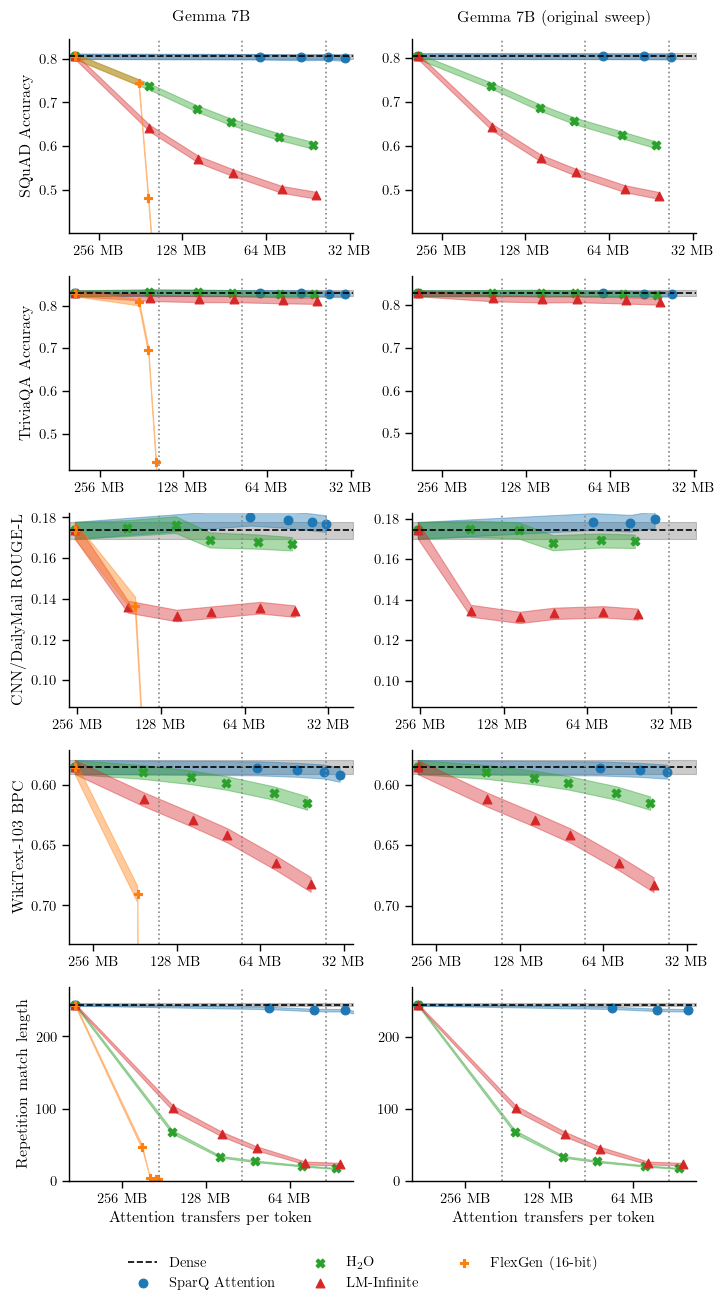

In [62]:
def show_tradeoffs(models: List[str], tasks: List[str], size: Tuple[float, float]) -> np.ndarray:
    fig, axs = plt.subplots(len(tasks), len(models), figsize=(size[0]*len(models), size[1]*len(tasks)), squeeze=False)
    for task, axr in zip(tasks, axs):
        for model, ax in zip(models, axr):
            show_tradeoff(model, task, title=(task == tasks[0]), xlabel=(task == tasks[-1]), ylabel=(model == models[0]),
                          model_label=False, vlines=[2, 4, 8], vlineslabel=False, ax=ax)
    plt.tight_layout(w_pad=0.5)
    fig.legend(*axs[0, 0].get_legend_handles_labels(), frameon=False,
               ncols=3, bbox_to_anchor=(0.0, -0.1, 1.0, 0.1), loc="upper center")
    return axs

sns.set_context("paper", font_scale=1.2)
show_tradeoffs(["gemma-7b", "gemma-7b-(original-sweep)"],
               ["squad", "triviaqa", "cnn_dailymail", "wikitext_bpc", "repetition"], (3.7, 2.5))
plt.show()

## Compare reallocation on/off

In [63]:
dense = (
    pd.concat([
        # Gemma-7B
        load_sweep("RMOE-94-gemma-sweep-v1"),
    ]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d[d.name == "dense"])
)

In [64]:
dense_scores = {task: dense[dense.task == task].score.to_numpy()[0] for task in dense.task}
lims = {x: [0.9*y, 1.1*y] for x, y in dense_scores.items()}

In [65]:
df = (
    pd.concat([
        # Gemma-7B
        load_sweep("RMOE-94-gemma-sweep-v1"),
    ]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d[(d.task != "wikitext_bpc") | (~d.model.isin(["llama-2-13b", "llama-2-7b"])) | d.wikitext_bugfix])
    .pipe(lambda d: d[(d.name != "ann") | (d.k == 128)])
    .pipe(lambda d: d[d["rank"] != 12])
    .pipe(lambda d: d[(~d.name.isin(["eviction", "local"])) | (d.k >= 192)])
    .pipe(lambda d: d[d.name == "ann"])
    [["task", "model", "name", "reallocate_to_mean_value", "k", "rank", "transfers", "score", "score_stderr", "experiment", "id"]]
)

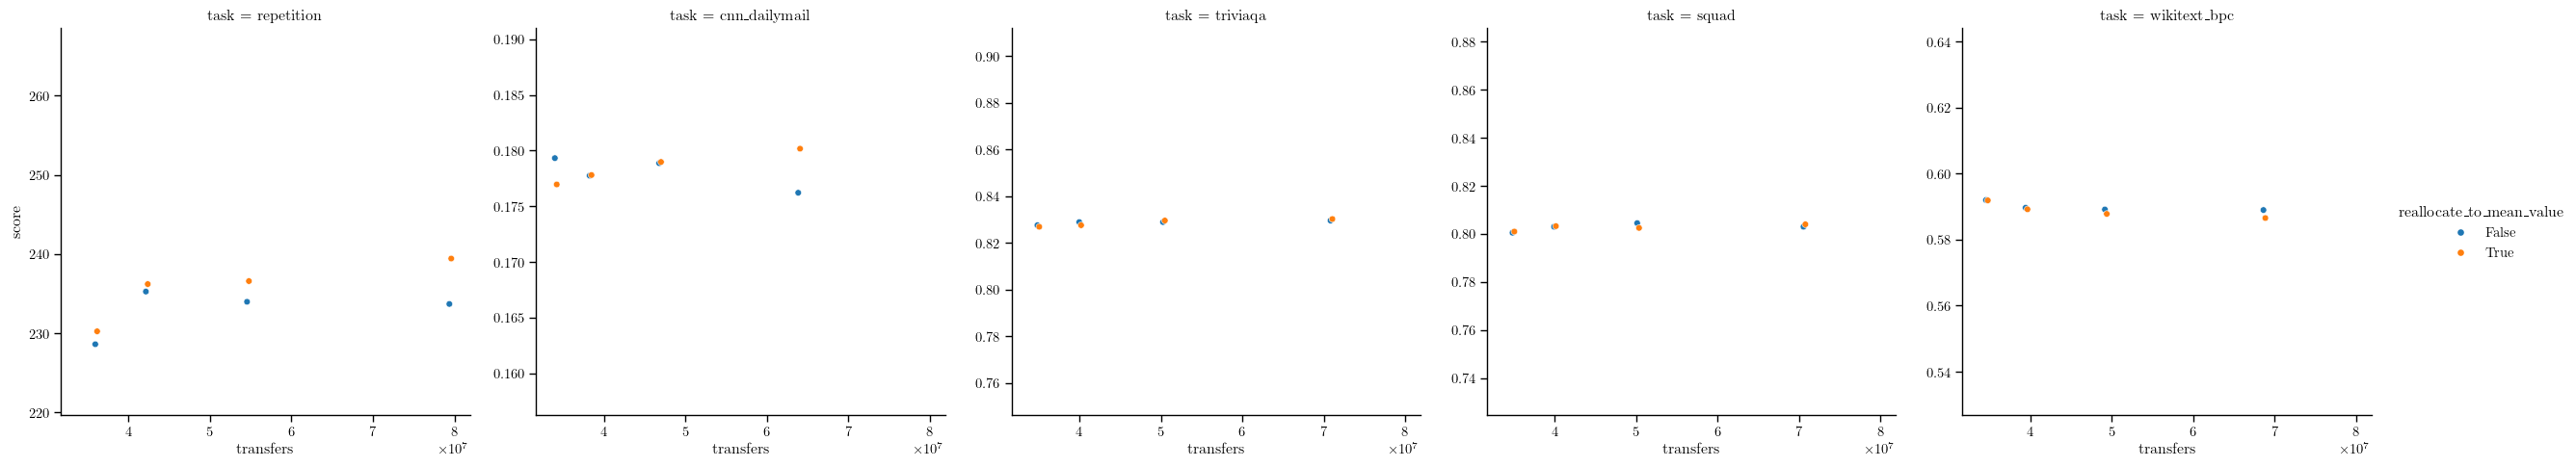

In [66]:
g = sns.relplot(df, x="transfers", y="score", hue="reallocate_to_mean_value", col="task", facet_kws={"sharey": False})
for ax, task in zip(g.axes.flat, df["task"].unique()):
    ax.set_ylim(lims.get(task, None))  # Use default limits if not specified